#  Mountain Green Cover Index

This notebook calculate the kapos range class for a study area and store the results as a tif file

In [1]:
%matplotlib inline

import os
import datacube
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from scipy.ndimage import uniform_filter, maximum_filter, minimum_filter

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from datacube.utils.cog import write_cog

In [2]:
dc = datacube.Datacube(app="kapos_range")

In [3]:
#cameroon
lon_range = (10.188, 10.934)
lat_range = (6.497, 5.872)

#Ghana
# lon_range = (-0.5823, -0.4298)
# lat_range = (6.5527, 6.4006)

In [4]:
display_map(lon_range, lat_range)

In [5]:
#set up daatcube query object
query = {
    'x': lon_range,
    'y': lat_range,
    'output_crs': 'epsg:6933',
}

In [6]:
ds = dc.load(product="dem_srtm", resolution=(-30, 30), measurements='elevation', **query)
ds

<xarray.Dataset>
Dimensions:      (time: 1, y: 2644, x: 2400)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 8.271e+05 8.271e+05 ... 7.479e+05 7.478e+05
  * x            (x) float64 9.83e+05 9.83e+05 9.831e+05 ... 1.055e+06 1.055e+06
    spatial_ref  int32 6933
Data variables:
    elevation    (time, y, x) int16 1113 1123 1133 1139 1139 ... 980 986 989 995
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [7]:
ds_slope = dc.load(product="dem_srtm_deriv", resolution=(-30, 30), measurements='slope', **query)
ds_slope

<xarray.Dataset>
Dimensions:      (time: 1, y: 2644, x: 2400)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 8.271e+05 8.271e+05 ... 7.479e+05 7.478e+05
  * x            (x) float64 9.83e+05 9.83e+05 9.831e+05 ... 1.055e+06 1.055e+06
    spatial_ref  int32 6933
Data variables:
    slope        (time, y, x) float32 38.67 37.31 31.12 ... 27.59 27.27 30.05
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [8]:
#Implmenting the reducers on the dem results
#var ler = dem.reduceNeighborhood({reducer: ee.Reducer.minMax(), 
#kernel: ee.Kernel.circle({radius:7000, units:’meter’})});

def reduce_nei(da, size, pre):
    img = da.values
    if pre == 'max':
        img = maximum_filter(img, size=size, mode='nearest')
    else:
        img = minimum_filter(img, size=size, mode='nearest')
    
    return img

In [9]:
ds["max"] = ds.elevation.groupby("time").apply(reduce_nei, size=233, pre='max')
ds["min"] = ds.elevation.groupby("time").apply(reduce_nei, size=233, pre='min')

In [10]:
ds["ler_range"] = ds["max"] - ds["min"]

### Generating Kapos range mountain classess

In [11]:
classess = [1, 2, 3, 4, 5, 6]

conditions = [
    (ds['elevation'] > 4500),
    (ds['elevation'] >= 3500) & (ds['elevation'] < 4500),
    (ds['elevation'] >= 2500) & (ds['elevation'] < 3500),
    (ds['elevation'] >= 1500) & (ds['elevation'] < 2500) & 
        (ds_slope['slope'] > 2),
    (ds['elevation'] >= 1000) & (ds['elevation'] < 1500) & 
        ((ds_slope['slope'] > 5) | (ds['ler_range'] > 300)),
    (ds['elevation'] >= 300) & (ds['elevation'] < 1000) & (ds['ler_range'] > 300)
    ]

In [12]:
ds['kapo_class'] = xr.DataArray(np.select(conditions, classess), coords={'time': ds.time, 'y': ds.y, 
                                'x': ds.x},
             dims=['time', 'y', 'x'])

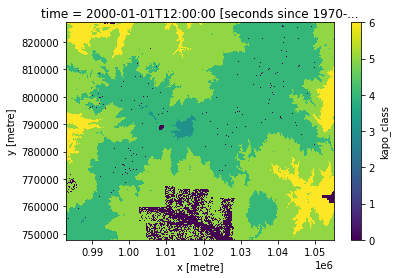

In [13]:
ds['kapo_class'].plot()

### Download the results

In [14]:
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [15]:
write_cog(ds['kapo_class'].astype('int8'),  'results/kapo.tif', overwrite=True)

PosixPath('results/kapo.tif')